# Fake News Detection

Beyond traditional tokenization, I also implemented alternative word segmentation techniques, which may help reduce redundant words.
- Split contractions (e.g. don't --> do not)
- Remove all numbers
- Transform words into lemmas or stems

For the news that has already been segmented, I select **three vectorization methods**: document frequency, TF-IDF within the Bag-of-Words models, and Word2Vec within the Word Embedding models. The purpose is to examine the impact of different word vectorization methods on downstream news classification task.

In the news classification, holding the hyperparameters fixed, I evaluated the performance of **four different machine learning models**: Gaussian Naive Bayes, Random Forest, Support Vector Machine, and Feedforward Neural Network (FNN). The purpose is to find the optimal combination of the word embedding method and machine learning model on classification task.


The conclusion is with the same word embedding dimensions fixed at 334, **the combination of Support Vector Machine model equipped with a nonlinear kernel and Word2Vec embedding method** gets the highest accuracy rate among 12 pairs, with a score of **approximately 93.7%**.

Reference:
- Ash, E., & Hansen, S. (2023). Text algorithms in economics. Annual Review of Economics, 15(Volume 15, 2023), 659–688. https://doi.org/10.1146/annurev-economics-082222-074352
- Heinrich, G. (2009). Parameter estimation for text analysis. https://www.semanticscholar.org/paper/Parameter-estimation-for-text-analysis-Heinrich/f22d042312f5f38eddaca08d49ef805c0d8f1cdc

Code Reference:
- https://github.com/sekhansen/text_algorithms_econ/blob/3d3042e96254a92a4bbcb181a33ced091de49724/notebooks/2_preprocessing.ipynb


## Data
- train.csv: A full training dataset with the following attributes:
    - id: unique id for a news article
    - title: the title of a news article
    - author: author of the news article
    - text: the text of the article; could be incomplete
    - label: a label that marks the article as potentially unreliable
        - 1: unreliable
        - 0: reliable

In this project, some packages used in natural language processing (NLP) need to be installed.

In [ ]:
%%capture

# NLP 
!pip3 install nltk 
!pip3 install flashtext
!pip3 install requests
!pip3 install jinja2

!pip3 install spacy
# Because I can't load via "!python3 -m spacy download en_core_web_sm"
# Download the language pack directly from the English · spaCy Models Documentation: https://spacy.io/models/en, and then load it by indexing to the file.
!pip3 install 'E:/2024XA/nlp/en_core_web_sm-3.8.0-py3-none-any.whl' 

# Word2Vec 
!pip3 install gensim 

In [ ]:
# clone the GitHub repository with the preprocessing scripts
# The stop word data provided by the author will be used later
!git clone https://github.com/unstructured-data-research/text-preprocessing


## 0 Load data
Load the dataset "train.csv" which has already been marked with labels indicating whether the news is real or fake. It can be seen from the table that there are a total of 20,800 pieces of news, and both the "title" column and the "text" column contain English texts that need to be preprocessed. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df.shape

(20800, 5)

In [4]:
# check missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [5]:
# Replace missing values with spaces
df = df.fillna(' ')

In [6]:
# View the information of the first row, 'text' column
df.loc[0,'text']

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [7]:
df.loc[0,'title']

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [8]:
# merge text messages
df['docs'] = df['title'] + ' ' + df['text']
docs = df['docs']

In [9]:
docs

0        House Dem Aide: We Didn’t Even See Comey’s Let...
1        FLYNN: Hillary Clinton, Big Woman on Campus - ...
2        Why the Truth Might Get You Fired Why the Trut...
3        15 Civilians Killed In Single US Airstrike Hav...
4        Iranian woman jailed for fictional unpublished...
                               ...                        
20795    Rapper T.I.: Trump a ’Poster Child For White S...
20796    N.F.L. Playoffs: Schedule, Matchups and Odds -...
20797    Macy’s Is Said to Receive Takeover Approach by...
20798    NATO, Russia To Hold Parallel Exercises In Bal...
20799    What Keeps the F-35 Alive   David Swanson is a...
Name: docs, Length: 20800, dtype: object

In [10]:
n_blankDocs = 0
for row in df['docs']:
    # Loops through each element (string) in the row
    if all(not cell.strip() for cell in row): # Is row blank? blank = true
        n_blankDocs += 1

n_blankDocs

0

## 1 Tokenization Stage
I grasp the significance of text preprocessing from this [GitHub post](https://github.com/sekhansen/text_algorithms_econ/blob/main/notebooks/2_preprocessing.ipynb). According to my own requirements, I referred to some of the author's code and developed my own tokenization approach.

### 1.1 Basic Cleaning

In [11]:
# lower case via the lower() built-in method
docs = [s.lower() for s in docs]

In [12]:
# remove leading and trailing whitespaces
docs = [d.strip() for d in docs]

In [13]:
# the library mainly supports English but it provides the tools to extend its
# functionality to other languages: https://github.com/kootenpv/contractions
import contractions

# Expand the abbreviations
contractions.fix("We can't increase the interest rate. They won't accept it. It's too risky.")

'We cannot increase the interest rate. They will not accept it. It is too risky.'

In [14]:
# apply contractions function
docs = list(map(lambda x: contractions.fix(x), docs))

In [15]:
docs[0]

'house dem aide: we did not even see comey’s letter until jason chaffetz tweeted it house dem aide: we did not even see comey’s letter until jason chaffetz tweeted it by darrell lucus on october 30, 2016 subscribe jason chaffetz on the stump in american fork, utah ( image courtesy michael jolley, available under a creative commons-by license) \nwith apologies to keith olbermann, there is no doubt who the worst person in the world is this week–fbi director james comey. but according to a house democratic aide, it looks like we also know who the second-worst person is as well. it turns out that when comey sent his now-infamous letter announcing that the fbi was looking into emails that may be related to hillary clinton’s email server, the ranking democrats on the relevant committees did not hear about it from comey. they found out via a tweet from one of the republican committee chairmen. \nas we now know, comey notified the republican chairmen and democratic ranking members of the house

In [16]:
import nltk 

# Customize regular expression pattern that preserves punctuation and splits hyphenated words
custom_pattern = r'''
                 (?x)                   # set flag to allow verbose regexps (to separate logical sections of pattern and add comments)
                 \w+                    # Match a single word. Two word parts connected by a hyphen "-", which will later be split into two tokens
                 | [][.,;"'?():-_`]     # Keep punctuation as separate tokens
                 '''

# apply the pattern
tokened_docs = list(map(lambda x: nltk.regexp_tokenize(x, pattern=custom_pattern), docs))

In [17]:
# inspect a document to see the tokenization
print(df.loc[0, "docs"][0:120], "\n")
print(tokened_docs[0][0:20]) 


House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It House Dem Aide: We Didn’t Even See Com 

['house', 'dem', 'aide', ':', 'we', 'did', 'not', 'even', 'see', 'comey', 's', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'it', 'house', 'dem', 'aide']


In [18]:
import unicodedata

# remove non-ascii characters via unicodedata package
def remove_non_ascii(tokens):
    tokens = [unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore') for t in tokens]
    return tokens
    
# apply function
tokened_docs = list(map(remove_non_ascii, tokened_docs))

In [19]:
print(tokened_docs[0][0:20])

['house', 'dem', 'aide', ':', 'we', 'did', 'not', 'even', 'see', 'comey', 's', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'it', 'house', 'dem', 'aide']


In [20]:
# remove extra white spaces and short tokens via simple list comprehension
def remove_short(tokened_docs, min_length=2):
    return [t.strip() for t in tokened_docs if t.strip() != '' and len(t.strip()) > min_length] 

# apply function
tokened_docs = list(map(remove_short, tokened_docs))

In [21]:
print(tokened_docs[0][0:20])

['house', 'dem', 'aide', 'did', 'not', 'even', 'see', 'comey', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'house', 'dem', 'aide', 'did', 'not', 'even', 'see']


In [22]:
import string
import re

# remove punctuation using a regular expression. We can use this same structure to remove any other character
def remove_punctuation(tokens, punctuation):            
    regex = re.compile('[%s]' % re.escape(punctuation))
    tokens = [regex.sub('', t) for t in tokens]
    return tokens

# load a list of punctuation signs
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
# apply function
tokened_docs = list(map(lambda x: remove_punctuation(x, string.punctuation), tokened_docs))
print(tokened_docs[0][0:16])

['house', 'dem', 'aide', 'did', 'not', 'even', 'see', 'comey', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'house', 'dem', 'aide']


In [24]:
import spacy
nlp_standard = spacy.load('en_core_web_sm')
import flashtext

import preprocessing_class as pc
import preprocess_data

d:\ProgramData\anaconda3\envs\fakenew\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [25]:
# remove stopwords
def remove_stopwords(tokens, stopwords):
    return [t for t in tokens if t not in stopwords]

# load a custom list of stopwords
custom_stopwords = list(preprocess_data.stp_long)
custom_stopwords[0:10]

['doing', 'but', 'with', 'each', 'i', 'put', 'two', 'do', 'new', 'in']

In [26]:
# apply stopword removal function
tokened_docs = list(map(lambda x: 
                  remove_stopwords(x, stopwords=custom_stopwords),
                  tokened_docs))

In [27]:
print(tokened_docs[0][0:20])

['house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'darrell', 'lucus', 'october', '2016']


In [28]:
# remove numbers
def remove_numbers(tokens, min_length=2):
    translation_table = str.maketrans('', '', string.digits)
    tokens = [t.translate(translation_table) for t in tokens if not t.isdigit()] 
    return  [t for t in tokens if t != '' and len(t) > min_length]

# apply number removal function
tokened_docs = list(map(lambda x: 
                  remove_numbers(x, min_length=2),
                  tokened_docs))

In [29]:
print(tokened_docs[0][0:20])

['house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'darrell', 'lucus', 'october', 'subscribe']


### 1.2 Lemmatization
>In morphology and lexicography, a lemma (pl.: lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of word forms. In English, for example, *break, breaks, broke, broken* and *breaking* are forms of the same lexeme, with *break* as the lemma by which they are indexed. Lexeme, in this context, refers to the set of all the inflected or alternating forms in the paradigm of a single word, and lemma refers to the particular form that is chosen by convention to represent the lexeme. — [Wikipedia](https://en.wikipedia.org/wiki/Lemma_(morphology))

I use lemmatization via [spaCy lemmatizer](https://spacy.io/api/lemmatizer) to reduce word redundancy to increase the efficiency of word vectorization.

In [30]:
# lemmatize with standard spaCy lemmatizer (takes a couple of minutes)
nlp_standard = spacy.load('en_core_web_sm')
def lemmatize(sent):
    sent = ' '.join(sent)
    doc = nlp_standard(sent)
    lemmas = [token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc]
    return lemmas

# apply function
lemmas_docs = list(map(lemmatize, tokened_docs))

In [31]:
count_lemmas = 0
for sub_list in lemmas_docs:
    for _ in sub_list:
        count_lemmas += 1
print("The total number of lemmas is:", count_lemmas)

The total number of lemmas is: 8120623


In [32]:
def text_lengths(token_list):
    text_lengths = [len(text) for text in token_list]
    min_length = min(text_lengths)
    max_length = max(text_lengths)
    average_length = sum(text_lengths)/len(text_lengths)
    median_length = sorted(text_lengths)[len(text_lengths)//2]
    print("The smallest number of tokens:", min_length)
    print("The biggest number of tokens:", max_length)
    print("Average number of tokens:", average_length)
    print("Median number of tokens:", median_length)

In [33]:
# calculates and prints the minimum, maximum, average, and median lengths
text_lengths(lemmas_docs)

The smallest number of tokens: 0
The biggest number of tokens: 11090
Average number of tokens: 390.4145673076923
Median number of tokens: 294


In [34]:
len(lemmas_docs)

20800

In [35]:
# total_count_ is a dictionary used to store the count of each list
total_count_ = {'tokened_docs': 0, 'lemmas_docs': 0}

# Iterate through these three lists and count them separately
for tokens_name, tokens in zip(['tokened_docs', 'lemmas_docs'], [tokened_docs, lemmas_docs]):
    for sub_list in tokens:
        # Count the elements of each sublist
        total_count_[tokens_name] += len(sub_list)

print(total_count_)


{'tokened_docs': 8113711, 'lemmas_docs': 8120623}


In [36]:
# show the tokenization for the first document
i = 0
print(df.loc[i, "docs"][0:162], "\n")
print("tokened_docs: ", tokened_docs[i][0:20], "\n")
print("Lemmas: ", lemmas_docs[i][0:20])

House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted I 

tokened_docs:  ['house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'darrell', 'lucus', 'october', 'subscribe'] 

Lemmas:  ['house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweet', 'house', 'dem', 'aide', 'comey', 'letter', 'jason', 'chaffetz', 'tweet', 'darrell', 'lucus', 'october', 'subscribe']


### 1.3 Restricting the Vocabulary by Looking at the Term Frequency
Drop very frequent terms, as they could be regarded as corpus-specific terms that do not add up much value.

Drop very rare terms, considering that not much can be learnt from such infrequent items.

The candidate measurements are Document Frequency (DF) or Term Frequency Inverse Document Frequency (TF-IDF). TF-IDF score for term $v$ is computed according to the formula below:

\begin{equation}
tfidf_v = (1+log(tf_v)) (log \frac{N}{df_v+1})
\end{equation}

where high weight is given to term that appears frequently in the entire dataset, but in relatively few documents

In [37]:
def do_nothing(docs):
    return docs

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from collections import defaultdict

def chunk_tokens(tokens, chunk_size):
    """Generator function to split tokens into chunks."""
    for i in range(0, len(tokens), chunk_size):
        yield tokens[i:i + chunk_size]

tokens = lemmas_docs  # token list
chunk_size = 10000  # Number of rows processed each time

# Dictionary to keep track of document frequency for each term
df_dict = defaultdict(int)

# Process tokens in chunks
for chunk in chunk_tokens(tokens, chunk_size):
    print(f"Processing chunk of size {len(chunk)}")

    # Generate document frequency ranking for the current chunk
    vectorizer = TfidfVectorizer(use_idf=False, norm=None, tokenizer=do_nothing, preprocessor=do_nothing)
    df_matrix = vectorizer.fit_transform(chunk)  # Term-document matrix for the chunk
    df_matrix_bool = (df_matrix > 0).astype(int)  # Binary matrix: 1 if term is present, 0 otherwise

    # Sum the binary matrix across rows to get document frequency for the chunk
    scores_df = df_matrix_bool.sum(axis=0).A1  # .A1 converts the matrix to a 1D array (dense form)

    # Update global document frequency dictionary
    for term, idx in vectorizer.vocabulary_.items():
        df_dict[term] += scores_df[idx]  # Increment document frequency for the term

# Now sort the terms by document frequency
sorted_terms = sorted(df_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted terms and their document frequencies
sorted_vocab_keys = [term for term, _ in sorted_terms]
sorted_scores_df = [score for _, score in sorted_terms]
df_ranking = list(zip(sorted_vocab_keys, sorted_scores_df))

# Convert document frequencies to log scale (using natural log)
log_sorted_scores_df = np.log(np.array(sorted_scores_df) + 1)  # Adding 1 to avoid log(0)
log_df_ranking = list(zip(sorted_vocab_keys, log_sorted_scores_df))


Processing chunk of size 10000


d:\ProgramData\anaconda3\envs\fakenew\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Processing chunk of size 10000
Processing chunk of size 800


In [39]:
# Display the top 10 terms by document frequency
df_ranking[:10]  

[('will', 12777),
 ('can', 11299),
 ('people', 11179),
 ('year', 11122),
 ('time', 10842),
 ('come', 9272),
 ('know', 9158),
 ('call', 8578),
 ('use', 8568),
 ('president', 8549)]

In [40]:
# Display the top 10 terms by log document frequency
log_df_ranking[:10] 

[('will', 9.455480221162288),
 ('can', 9.332558004700433),
 ('people', 9.32188174670909),
 ('year', 9.316770315592029),
 ('time', 9.291274989472182),
 ('come', 9.134862230800225),
 ('know', 9.122492281402987),
 ('call', 9.057072635572965),
 ('use', 9.055906318669118),
 ('president', 9.053686561930807)]

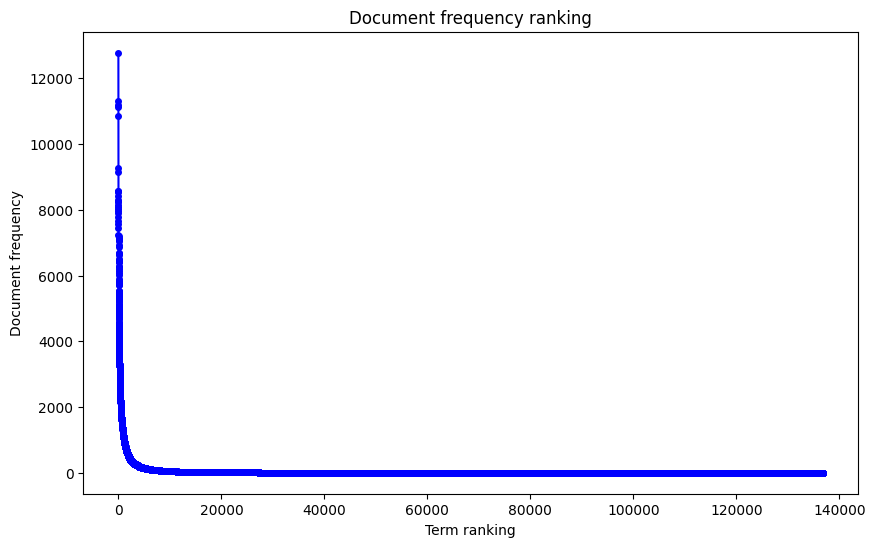

In [41]:
# plot document frequency
# Extract the ranks and document frequencies from df_ranking
ranks = np.arange(1, len(df_ranking) + 1)  # Rank starts from 1
df_frequencies = [score for _, score in df_ranking]  # Document frequencies

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ranks, df_frequencies, marker='o', linestyle='-', color='b', markersize=4)

plt.title('Document frequency ranking')
plt.ylabel("Document frequency")
plt.xlabel("Term ranking")
plt.show()


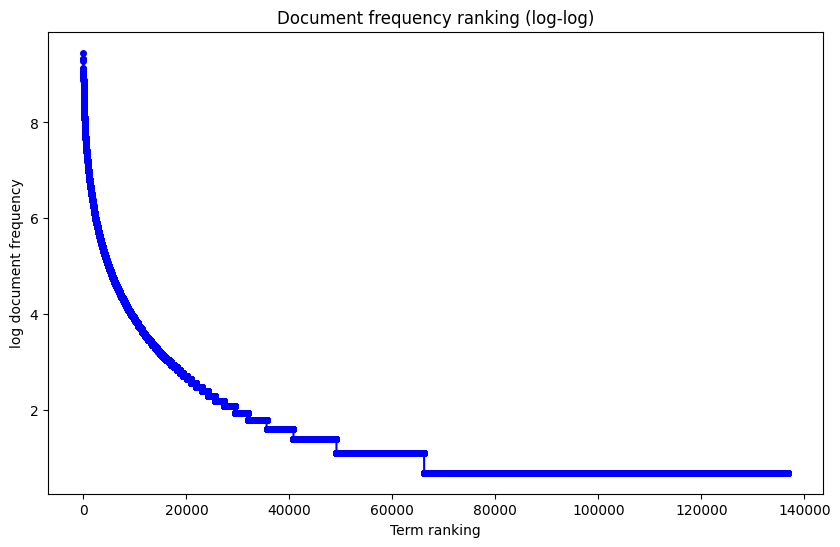

In [42]:
# plot log document frequency
# Extract the ranks and document frequencies from log_df_ranking
ranks2 = np.arange(1, len(log_df_ranking) + 1)  
df_frequencies2 = [score for _, score in log_df_ranking]  

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ranks2, df_frequencies2, marker='o', linestyle='-', color='b', markersize=4)

plt.title('Document frequency ranking (log-log)')
plt.ylabel("log document frequency")
plt.xlabel("Term ranking")
plt.show()


In [43]:
import numpy as np
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to compute term-frequency inverse document frequency (TF-IDF)
def tf_idf_compute(term, num_docs, scores_tf, scores_df):
    return (1 + np.log(scores_tf[term])) * np.log(num_docs / (1 + scores_df[term]))

# Function to chunk tokens
def chunk_tokens(tokens, chunk_size):
    """Generator function to split tokens into chunks."""
    for i in range(0, len(tokens), chunk_size):
        yield tokens[i:i + chunk_size]

tokens = lemmas_docs  # token list
chunk_size = 10000  # Number of rows processed each time

# Dictionary to keep track of term frequency and document frequency for each term
tf_dict = defaultdict(int)  # Term frequency dictionary
df_dict = defaultdict(int)  # Document frequency dictionary
tfidf_dict = defaultdict(float)  # Final TF-IDF values

# Process tokens in chunks
for chunk in chunk_tokens(tokens, chunk_size):
    print(f"Processing chunk of size {len(chunk)}")

    # Generate term-document matrix for the current chunk
    vectorizer = TfidfVectorizer(use_idf=False, norm=None, tokenizer=do_nothing, preprocessor=do_nothing)
    df_matrix = vectorizer.fit_transform(chunk)  # Term-document matrix for the chunk

    # Sum the word frequency matrix across rows to get term frequency for the chunk
    scores_tf = df_matrix.sum(axis=0).A1  # Convert to a 1D array

    # Update document frequency dictionary for each term in the current chunk
    df_matrix_bool = (df_matrix > 0).astype(int)  # Binary matrix (1 if term is present in doc)
    for term, idx in vectorizer.vocabulary_.items():
        df_dict[term] += df_matrix_bool[0, idx]  # Increment document frequency for the term
        tf_dict[term] += scores_tf[idx]  # Increment term frequency for the term

# Calculate TF-IDF for each term across all chunks
num_docs = len(tokens)  # Total number of documents (chunks processed)
for term in df_dict:
    tfidf_dict[term] = tf_idf_compute(term, num_docs, tf_dict, df_dict)

# Sort the terms by their TF-IDF values in descending order
sorted_terms_tfidf = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted terms and their TF-IDF scores
sorted_vocab_keys_tfidf = [term for term, _ in sorted_terms_tfidf]
sorted_scores_tfidf = [score for _, score in sorted_terms_tfidf]

# Display the top 10 terms by TF-IDF
tfidf_ranking = list(zip(sorted_vocab_keys_tfidf, sorted_scores_tfidf))
tfidf_ranking[:10]  # Top 10 ranked terms by TF-IDF


Processing chunk of size 10000
Processing chunk of size 10000
Processing chunk of size 800


[('will', 109.05689118939922),
 ('come', 107.98617336245603),
 ('country', 107.19327147567667),
 ('people', 106.59651173987884),
 ('report', 106.31873987639543),
 ('trump', 106.17730112704649),
 ('want', 105.99891485781848),
 ('news', 105.8790833442459),
 ('year', 105.64778503620207),
 ('take', 105.6382840318702)]

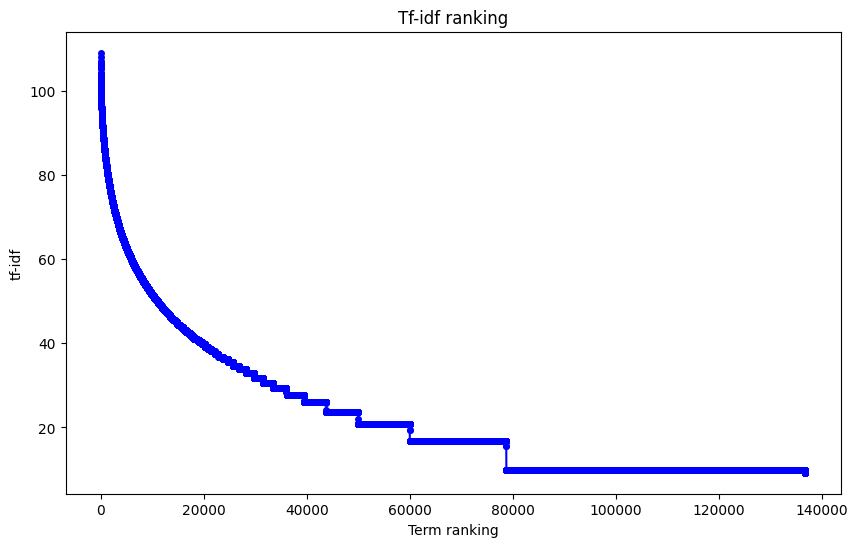

In [44]:
# plot TF-IDF
# Extract the ranks and document frequencies from df_ranking
tfidf_ranks = np.arange(1, len(tfidf_ranking) + 1)  # Rank starts from 1
tfidf_frequencies = [score for _, score in tfidf_ranking]  # Document frequencies

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(tfidf_ranks, tfidf_frequencies, marker='o', linestyle='-', color='b', markersize=4)

plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()


Using the TF-IDF ranking, I remove lemmas that have scores lower than the score of lemma in positions around 60,000 or greater than the score of lemma in positions around 100.

In [45]:
# get the score of the stem in position 60000
tfidf_ranking[60000][1]

16.834468467182088

In [46]:
# get the upper limit
tfidf_ranking[100][1]

96.79908511268569

In [47]:
# Check how many unique words there are
print(len(tfidf_ranking)) 

136787


In [48]:
# auxiliary function to easily remove undesired tokens
def remove(tokens, to_remove):
    if to_remove:
        return [t for t in tokens if t not in to_remove]
    else:
        return tokens

# function to remove tokens in documents according to their df or tfidf score 
def rank_remove(ranking, docs, min_cutoff_score, max_cutoff_score):

    # define list of tokens to remove
    to_remove_low = set([t[0] for t in ranking if t[1] <= min_cutoff_score])
    to_remove_high = set([t[0] for t in ranking if t[1] > max_cutoff_score])

    # remove tokens
    docs_clean = [remove(d, to_remove_low) for d in docs]
    docs_clean = [remove(d, to_remove_high) for d in docs_clean] 

    return docs_clean

In [49]:
lemmas_clean = rank_remove(tfidf_ranking, lemmas_docs, min_cutoff_score=tfidf_ranking[60000][1], max_cutoff_score=tfidf_ranking[100][1])

In [50]:
# The number of lemmas after restriction
words_count = 0
for tokens in lemmas_clean:
    words_count += len(tokens)

print(words_count)

6755351


In [51]:
# Number of lemmas before limit
words_count = 0
for tokens in lemmas_docs:
    words_count += len(tokens)

print(words_count)

8120623


In [52]:
len(lemmas_clean)

20800

In [53]:
# calculates and prints the minimum, maximum, average, and median lengths
text_lengths(lemmas_clean)

The smallest number of tokens: 0
The biggest number of tokens: 8745
Average number of tokens: 324.7764903846154
Median number of tokens: 243


## 2 Vectorization
I select four vectorization representations, specifically Document Frequency and TF-IDF within the Bag-of-Words model, Word2Vec within the Word Embedding model, and Convolutional Neural Network (CNN) within the Deep Learning model.

### 2.1 Bag of Words

#### 2.1.1 Word frequency

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

In [55]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

In [56]:
# we can also create a weighted vectorizer object
# however we will not use it in the analysis
vectorizer = CountVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                      tokenizer=do_nothing,                 # apply no additional tokenization
                                      lowercase=False,                      # convert all characters to lower-case
                                      strip_accents=None,                   # remove non-ascii characters
                                      stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                      ngram_range=(1, 1),                   # generate only unigrams
                                      analyzer='word',                      # analysis at the word-level 
                                      max_df=0.9,                           # ignore tokens that have a higher document frequency (can be int or percent)
                                      min_df=0.1,                           # ignore tokens that have a lowe document frequency (can be int or percent)
                                      max_features=None,                    # we could impose a maximum number of vocabulary terms
                                   )                       

vectorizer


,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,False
,preprocessor,<function do_...0012E2DA7C550>
,tokenizer,<function do_...0012E2DA7C550>
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [57]:
# create the document term matrix using cleanedlemmas
df_matrix = vectorizer.fit_transform(lemmas_clean).toarray()
vocabulary_custom = vectorizer.vocabulary_
print(len(vocabulary_custom))

334


In [58]:
vocabulary_custom = sorted(vocabulary_custom)
vocabulary_custom[:10]

['able',
 'accord',
 'account',
 'across',
 'act',
 'action',
 'actually',
 'add',
 'address',
 'agency']

In [59]:
# another way of looking at the vocabulary (ordered by index in the document-term matrix)
vectorizer.get_feature_names_out()

array(['able', 'accord', 'account', 'across', 'act', 'action', 'actually',
       'add', 'address', 'agency', 'ago', 'agree', 'allow', 'almost',
       'along', 'already', 'although', 'always', 'among', 'announce',
       'anyone', 'anything', 'appear', 'area', 'around', 'article',
       'attempt', 'authority', 'away', 'bad', 'base', 'become', 'behind',
       'big', 'bill', 'black', 'book', 'break', 'build', 'call',
       'candidate', 'care', 'carry', 'case', 'cause', 'center',
       'challenge', 'charge', 'chief', 'choose', 'clear', 'com',
       'comment', 'community', 'concern', 'congress', 'consider',
       'control', 'course', 'court', 'cover', 'current', 'cut', 'daily',
       'deal', 'death', 'decade', 'decide', 'decision', 'democratic',
       'describe', 'despite', 'die', 'different', 'director', 'discuss',
       'do', 'donald', 'drive', 'early', 'economic', 'effort', 'either',
       'elect', 'email', 'enough', 'especially', 'event', 'everyone',
       'everything', 'ev

In [60]:
print(df_matrix.shape)  # The shape of the output array
print(df_matrix.dtype)  # Output the data type of array elements, such as float64, etc.

(20800, 334)
int64


#### 2.1.2 TF-IDF

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
# we can also create a weighted vectorizer object
# however we will not use it in the analysis
weighted_vectorizer = TfidfVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                      tokenizer=do_nothing,                 # apply no additional tokenization
                                      lowercase=False,                      # convert all characters to lower-case
                                      strip_accents=None,                   # remove non-ascii characters
                                      stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                      ngram_range=(1, 1),                   # generate only unigrams
                                      analyzer='word',                      # analysis at the word-level 
                                      max_df=0.9,                           # ignore tokens that have a higher document frequency (can be int or percent)
                                      min_df=0.1,                           # ignore tokens that have a lowe document frequency (can be int or percent)
                                      max_features=None,                    # we could impose a maximum number of vocabulary terms
                                      
                                      use_idf=True,                         # wether to apply inverse document frequency weights
                                      smooth_idf=True,                      # add +1 to idf weighting
                                      sublinear_tf=True                     # add +1 to log(tf)
                                   )                       


weighted_df_matrix = weighted_vectorizer.fit_transform(lemmas_clean).toarray()

In [63]:
print(weighted_df_matrix.shape)  
print(weighted_df_matrix.dtype)  

(20800, 334)
float64


In [64]:
weighted_vocabulary_custom = weighted_vectorizer.vocabulary_
print(len(weighted_vocabulary_custom))

334


In [65]:
# another way of looking at the vocabulary (ordered by index in the document-term matrix)
weighted_vectorizer.get_feature_names_out()

array(['able', 'accord', 'account', 'across', 'act', 'action', 'actually',
       'add', 'address', 'agency', 'ago', 'agree', 'allow', 'almost',
       'along', 'already', 'although', 'always', 'among', 'announce',
       'anyone', 'anything', 'appear', 'area', 'around', 'article',
       'attempt', 'authority', 'away', 'bad', 'base', 'become', 'behind',
       'big', 'bill', 'black', 'book', 'break', 'build', 'call',
       'candidate', 'care', 'carry', 'case', 'cause', 'center',
       'challenge', 'charge', 'chief', 'choose', 'clear', 'com',
       'comment', 'community', 'concern', 'congress', 'consider',
       'control', 'course', 'court', 'cover', 'current', 'cut', 'daily',
       'deal', 'death', 'decade', 'decide', 'decision', 'democratic',
       'describe', 'despite', 'die', 'different', 'director', 'discuss',
       'do', 'donald', 'drive', 'early', 'economic', 'effort', 'either',
       'elect', 'email', 'enough', 'especially', 'event', 'everyone',
       'everything', 'ev

### 2.2 Word Embedding


#### 2.2.1 Word2Vec

In [66]:
from gensim.models import Word2Vec

# Train word2vec model (it takes a while to run)
wordmodel = Word2Vec(lemmas_clean, 
                     vector_size=334,       # Represent each word as a 334-dimensional vector
                     window=5,              # Consider a window of 5 words on either side of the current word when learning vector representations
                     min_count=5,           # Ignore words that appear less than 5 times in the corpus
                     workers=4)             # Use 4 worker threads for parallel processing

wordmodel.train(lemmas_clean, total_examples=len(lemmas_clean), epochs=100)

(669918569, 675535100)

In [67]:
len(wordmodel.wv)

43676

In [68]:
wordmodel.wv['ago']

array([-2.0804753e+00,  5.6308520e-01,  6.2451456e-03, -1.0490555e+00,
       -1.8564795e+00, -2.7594626e+00,  1.3249642e-01,  1.0064106e+00,
        6.9140589e-01,  8.0650580e-01, -3.5721847e-01, -9.8098159e-01,
        1.3187206e-01, -1.5554276e+00,  7.3926258e-01,  1.1837835e+00,
        1.6880199e-02, -3.5287482e-01, -9.7418326e-01, -5.5833463e-02,
       -9.2835671e-01,  1.2560213e-01, -1.0210060e+00,  9.6055859e-01,
        2.3354803e-01,  1.3834229e-02,  1.4077731e+00, -4.5982042e-01,
        3.4891558e-01,  1.5712039e+00,  4.6212462e-01,  7.7718955e-01,
        8.9586325e-02, -6.7537457e-02, -7.7985018e-01,  1.9955544e+00,
        5.8431518e-01, -2.5737140e-01, -2.8646591e-01, -3.1117457e-01,
        1.4348511e+00,  1.3957076e+00, -6.4800233e-01, -1.3595168e-01,
       -1.4869668e+00,  8.3491987e-01,  1.7027299e+00,  6.0100478e-01,
       -1.6785274e+00,  7.3197842e-01,  5.5591601e-01,  2.8416544e-01,
       -2.0999269e+00, -1.1407803e+00,  7.6845688e-01,  9.3527526e-02,
      

In [69]:
# average (mean) the word embeddings in the document
def doc_vector(tokened_docs):
    # Keep only words that appear in the model’s vocabulary
    words = [w for w in tokened_docs if w in wordmodel.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(wordmodel.vector_size)  # handle empty docs
    return np.mean(wordmodel.wv[words], axis=0)

In [70]:
word2vec_metric = np.array([doc_vector(lemmas_doc) for lemmas_doc in lemmas_clean])

In [71]:
word2vec_metric.shape

(20800, 334)

## 3 Machine Learning for Classification Tasks

Based on the input features and the news classification task, I adopted four machine learning models, namely Gaussian Naive Bayes model, Random Forest model, Support Vector Machine model and Feedforward Neural Network model.

For each machine learning model, I input above three word embedding vectors. The purpose is to compare the accuracy rate among different combinations of vectorization methods and machine learning models.

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [125]:
y = df['label']

In [126]:
def split(X, y): 
    # The first split, 80% training set, 20% temporary set (validation set + test set)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    # Second split, 50% validation set, 50% test set
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    print(X_train.shape, X_val.shape, X_test.shape)
    
    # Adjust the data to a distribution with mean 0 and standard deviation 1
    # Helps improve the training effect of models, especially distance-based models or models optimized by gradient descent
    # In tree-based models, standardization does not necessarily have a significant impact on model performance.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)  # Use only the normalized parameters of the training set
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test
    

In [ ]:
# List of feature matrices
matrix_list = [word2vec_metric, weighted_df_matrix, df_matrix]
names = ["word2vec", "weighted_df", "df"]

# To store split data
splits = {}

for name, mat in zip(names, matrix_list):
    print(f"\n=== Splitting {name} matrix ===")
    X_train, X_val, X_test, y_train, y_val, y_test = split(mat, y)
    
    splits[name] = {
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test
    }
    
    print(f"{name}: Train shape {X_train.shape}, Validation shape {X_val.shape}, Test shape {X_test.shape}")


=== Splitting word2vec matrix ===
(16640, 334) (2080, 334) (2080, 334)
word2vec: Train shape (16640, 334), Test shape (2080, 334)

=== Splitting weighted_df matrix ===
(16640, 334) (2080, 334) (2080, 334)
weighted_df: Train shape (16640, 334), Test shape (2080, 334)

=== Splitting df matrix ===
(16640, 334) (2080, 334) (2080, 334)
df: Train shape (16640, 334), Test shape (2080, 334)


In [128]:
Xtrain1, Xval1, Xtest1, ytrain1, yval1, ytest1 = (
    splits['word2vec']['X_train'],
    splits['word2vec']['X_val'],
    splits['word2vec']['X_test'],
    splits['word2vec']['y_train'],
    splits['word2vec']['y_val'],
    splits['word2vec']['y_test']
)


In [129]:
Xtrain2, Xval2, Xtest2, ytrain2, yval2, ytest2 = (
    splits['weighted_df']['X_train'],
    splits['weighted_df']['X_val'],
    splits['weighted_df']['X_test'],
    splits['weighted_df']['y_train'],
    splits['weighted_df']['y_val'],
    splits['weighted_df']['y_test']
)


In [130]:
Xtrain3, Xval3, Xtest3, ytrain3, yval3, ytest3 = (
    splits['df']['X_train'],
    splits['df']['X_val'],
    splits['df']['X_test'],
    splits['df']['y_train'],
    splits['df']['y_val'],
    splits['df']['y_test']
)


### 3.1 Gaussian Naive Bayes
The Gaussian Naive Bayes classifier is a variant of the **Naive Bayes classification algorithm**, which assumes that the distribution of features follows a Gaussian distribution (i.e. a normal distribution). This model is often used to handle continuous data, and performs well especially if the data features follow a normal distribution.

**Advantages:** 
- Simple and efficient: Gaussian Naive Bayes is computationally simple and highly efficient, especially when dealing with large datasets.
- Efficient training and prediction: Training and prediction have lower time complexity because it only requires computing the mean and variance for each class.
- Suitable for high-dimensional data: In high-dimensional data (such as word frequency features in text classification tasks), Gaussian Naive Bayes can handle high-dimensional features without being susceptible to overfitting.

**Disadvantages:**  
- Feature independence assumption: Naive Bayes assumes that features are conditionally independent, which is often not true in practical applications and may reduce the accuracy of the model.
- Sensitive to outliers: Because the Gaussian distribution is very sensitive to outliers, outliers in the training data can significantly affect the mean and variance, which in turn affect the classification results.
- Assuming features follow a Gaussian distribution: if the actual distribution of the data is not Gaussian, model performance may degrade

In [131]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()


In [132]:
# vectorize matrix using Word2Vec
# Evaluate the model using cross-validation
scores1 = cross_val_score(gnb_model, Xtrain1, ytrain1, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores1.mean():.4f} ± {scores1.std():.4f}")

Cross-validation score: 0.6833 ± 0.0071


In [133]:
# vectorize matrix using TF-IDF
# Evaluate the model using cross-validation
scores2 = cross_val_score(gnb_model, Xtrain2, ytrain2, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores2.mean():.4f} ± {scores2.std():.4f}")

Cross-validation score: 0.8108 ± 0.0030


In [134]:
# vectorize matrix using document frequency
# Evaluate the model using cross-validation
scores3 = cross_val_score(gnb_model, Xtrain3, ytrain3, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores3.mean():.4f} ± {scores3.std():.4f}")

Cross-validation score: 0.7559 ± 0.0044


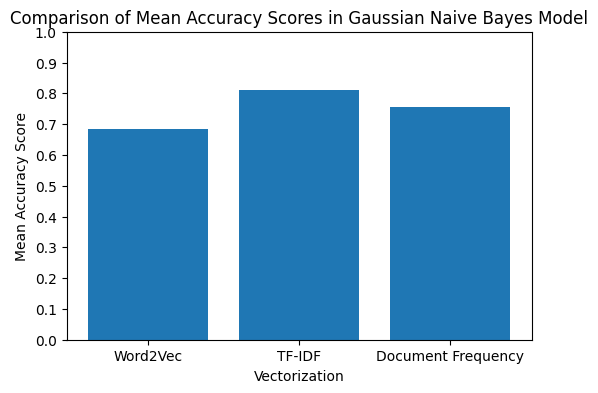

In [135]:
import matplotlib.pyplot as plt

index = ['Word2Vec', 'TF-IDF', 'Document Frequency']  #  Categories on the x-axis
score = [scores1.mean(), scores2.mean(), scores3.mean()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(6,4))
plt.ylim([0, 1])
plt.yticks([i * 0.1 for i in range(11)])
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Mean Accuracy Score')  
plt.title('Comparison of Mean Accuracy Scores in Gaussian Naive Bayes Model') 

plt.show()


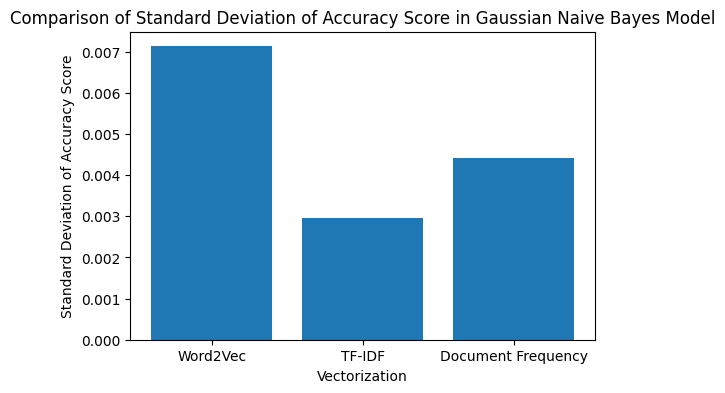

In [136]:
index = ['Word2Vec', 'TF-IDF', 'Document Frequency']  #  Categories on the x-axis
score = [scores1.std(), scores2.std(), scores3.std()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(6,4))
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Standard Deviation of Accuracy Score')  
plt.title('Comparison of Standard Deviation of Accuracy Score in Gaussian Naive Bayes Model') 

plt.show()


**Conclusion:**

It can be clearly seen from the above results that when the settings of the Gaussian Naive Bayes classifier are the same, using the TF-IDF vectorization matrix to classify news, the mean and standard deviation of the model accuracy obtained through cross-validation both show relatively excellent performance. This phenomenon indicates that in this news classification scenario, compared with other input features, the combination of **TF-IDF and the Gaussian Naive Bayes classifier** is more excellent and its generalization ability is also better.

In [137]:
# Use the best combination for final model evaluation
# vectorize matrix using TF-IDF
# Train the model on the training data
gnb_model.fit(Xtrain2, ytrain2)

# Predict on the test data
ypred = gnb_model.predict(Xtest2)

# Evaluate the model accuracy
gnb_accuracy = accuracy_score(ytest2, ypred)

# Output the evaluation result
print('Final Test Accuracy:', gnb_accuracy)

Final Test Accuracy: 0.8177884615384615


### 3.2 Random Forest
Random forest is an ensemble learning algorithm and belongs to the decision tree family. It constructs multiple decision trees and combines their prediction results to improve classification performance. The core idea of random forest is to reduce overfitting and enhance the generalization ability of the model by introducing randomness and ensemble.

**Advantages:**
- High accuracy: By integrating multiple decision trees, random forest usually has a high classification accuracy, especially suitable for large datasets and high-dimensional data.
- Strong resistance to overfitting: Since each tree is trained based on different subsets of samples and features, and the model makes decisions by voting, it can effectively avoid overfitting of a single decision tree.
- Wide applicability: It can handle various types of data, including numerical and categorical features, and also has a relatively good handling of missing values.
- Feature importance: Random forest can calculate the importance of each feature, which is very useful for feature selection and model interpretation.
- Ability to handle large-scale data: It can be trained on relatively large datasets and supports parallel processing, with a relatively fast training speed.

**Disadvantages:**
- Poor model interpretability: As it is an ensemble model, it is difficult to interpret and understand as intuitively as a single decision tree.
- High computational cost: Training multiple trees requires a large amount of computational resources. Especially when the number of samples and features is extremely large, the training time may be relatively long.
- High memory consumption: It needs to store multiple decision trees, so the memory overhead is relatively large, especially when using a large number of trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest classifier
rf_model = RandomForestClassifier(n_estimators=200, # The number of decision trees in the model. Increasing the number of trees generally improves model accuracy, but also increases computational overhead
                                 max_depth=5,  # The maximum depth of the tree. Limiting the depth of the tree prevents overfitting. Depending on the size and characteristics of the dataset, different depths can be tried. Small data sets can use larger depth to prevent underfitting
                                 random_state=42)


In [141]:
# vectorize matrix using Word2Vec
# Evaluate the model using cross-validation
scores1 = cross_val_score(rf_model, Xtrain1, ytrain1, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores1.mean():.4f} ± {scores1.std():.4f}")

Cross-validation score: 0.8307 ± 0.0037


In [142]:
# vectorize matrix using TF-IDF
# Evaluate the model using cross-validation
scores2 = cross_val_score(rf_model, Xtrain2, ytrain2, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores2.mean():.4f} ± {scores2.std():.4f}")

Cross-validation score: 0.8685 ± 0.0060


In [143]:
# vectorize matrix using document frequency
# Evaluate the model using cross-validation
scores3 = cross_val_score(rf_model, Xtrain3, ytrain3, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores3.mean():.4f} ± {scores3.std():.4f}")

Cross-validation score: 0.8702 ± 0.0037


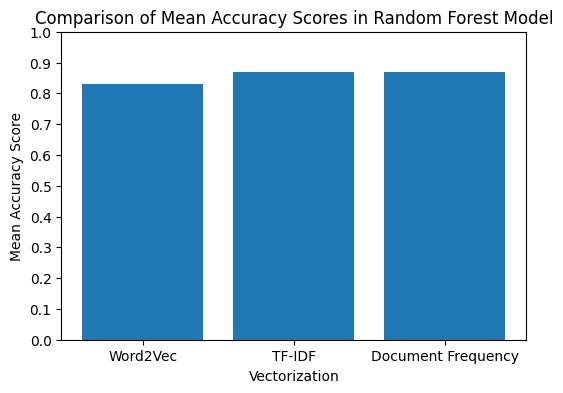

In [144]:

index = ['Word2Vec', 'TF-IDF', 'Document Frequency']  #  Categories on the x-axis
score = [scores1.mean(), scores2.mean(), scores3.mean()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(6,4))
plt.ylim([0, 1])
plt.yticks([i * 0.1 for i in range(11)])
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Mean Accuracy Score')  
plt.title('Comparison of Mean Accuracy Scores in Random Forest Model') 

plt.show()

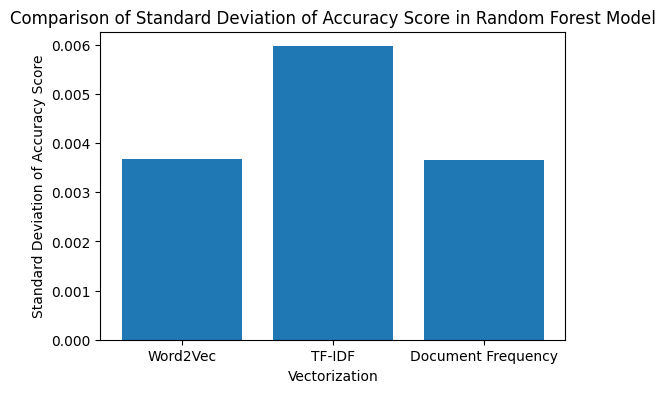

In [145]:
index = ['Word2Vec', 'TF-IDF', 'Document Frequency']  #  Categories on the x-axis
score = [scores1.std(), scores2.std(), scores3.std()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(6,4))
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Standard Deviation of Accuracy Score')  
plt.title('Comparison of Standard Deviation of Accuracy Score in Random Forest Model') 

plt.show()

**Conclusion:**

It can be clearly seen from the above results that when the settings of the random forest model are the same, using the Document Frequency vectorization matrix to classify news, the mean and standard deviation of the model accuracy obtained through cross-validation both show relatively excellent performance. This phenomenon indicates that in this news classification scenario, compared with other input features, the combination of **Document Frequency and the Random Forest model** is more excellent and its generalization ability is also better.

In [170]:
# Use the best combination for final model evaluation
# vectorize matrix using TF-IDF
# Train the model on the training data
rf_model.fit(Xtrain3, ytrain3)

ypred = rf_model.predict(Xtest3) 

rf_accuracy = accuracy_score(ytest3, ypred)

# Output evaluation report
print('Final Test Accuracy:', rf_accuracy)

Final Test Accuracy: 0.8783653846153846


### 3.3 Support Vector Machine
The Support Vector Machine (SVM) is a powerful supervised learning algorithm, which is widely used in classification and regression tasks. Its core idea is to find a hyperplane (or a set of hyperplanes) in the feature space to separate data points of different classes and maximize the margin between classes so as to improve the generalization ability of the model.

**Advantages:**
- High efficiency: For high-dimensional data (such as in text classification, image classification, etc.), the SVM performs excellently.
- Good generalization ability: By maximizing the margin, the SVM can effectively avoid overfitting, especially suitable for small-sample learning.
- Low memory requirement: The SVM only needs to store the support vectors, so it is relatively efficient when dealing with high-dimensional data.

**Disadvantages:**
- High computational cost: When the number of samples is large, the computational complexity of the training process is relatively high, especially when dealing with larger datasets or higher-dimensional feature data.
- Sensitivity to noise: Although the use of soft margin can tolerate some classification errors, the SVM is still relatively sensitive to noise and outliers.
- Difficulty in selecting kernel functions: In some cases, it may be rather difficult to select appropriate kernel functions and parameters (such as C and γ).

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svc_model = SVC(kernel='rbf', C=1.0)


In [148]:
# vectorize matrix using Word2Vec
# Evaluate the model using cross-validation
scores1 = cross_val_score(svc_model, Xtrain1, ytrain1, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores1.mean():.4f} ± {scores1.std():.4f}")

Cross-validation score: 0.9317 ± 0.0004


In [149]:
# vectorize matrix using TF-IDF
# Evaluate the model using cross-validation
scores2 = cross_val_score(svc_model, Xtrain2, ytrain2, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores2.mean():.4f} ± {scores2.std():.4f}")

Cross-validation score: 0.9170 ± 0.0030


In [150]:
# vectorize matrix using document frequency
# Evaluate the model using cross-validation
scores3 = cross_val_score(svc_model, Xtrain3, ytrain3, cv=5)

# Output cross-validation score
print(f"Cross-validation score: {scores3.mean():.4f} ± {scores3.std():.4f}")

Cross-validation score: 0.8986 ± 0.0060


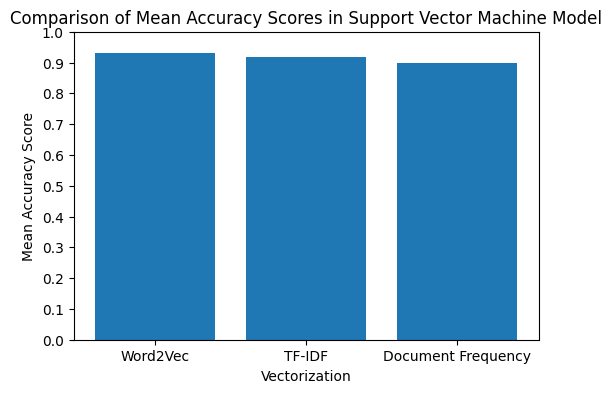

In [151]:
index = ['Word2Vec', 'TF-IDF', 'Document Frequency']  #  Categories on the x-axis
score = [scores1.mean(), scores2.mean(), scores3.mean()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(6,4))
plt.ylim([0, 1])
plt.yticks([i * 0.1 for i in range(11)])
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Mean Accuracy Score')  
plt.title('Comparison of Mean Accuracy Scores in Support Vector Machine Model') 

plt.show()

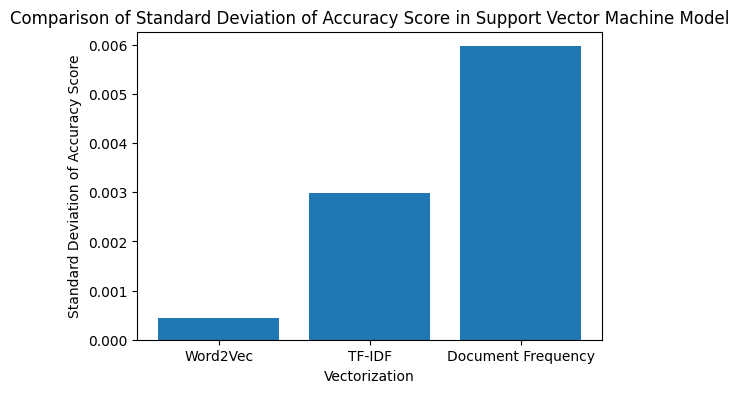

In [152]:
index = ['Word2Vec', 'TF-IDF', 'Document Frequency']  #  Categories on the x-axis
score = [scores1.std(), scores2.std(), scores3.std()]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(6,4))
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Standard Deviation of Accuracy Score')  
plt.title('Comparison of Standard Deviation of Accuracy Score in Support Vector Machine Model') 

plt.show()

**Conclusion:**

It can be clearly seen from the above results that when the settings of the Gaussian Naive Bayes classifier are the same, using the Word2Vec vectorization matrix to classify news, the mean and standard deviation of the model accuracy obtained through cross-validation both show relatively excellent performance. This phenomenon indicates that in this news classification scenario, compared with other input features, the combination of **Word2Vec and the Support Vector Machine model** is more excellent and its generalization ability is also better.

In [171]:
# Use the best combination for final model evaluation
# vectorize matrix using TF-IDF
# Train the model on the training data
svc_model.fit(Xtrain1, ytrain1)

ypred = svc_model.predict(Xtest1) 

svc_accuracy = accuracy_score(ytest1, ypred)

# Output the evaluation result
print('Final Test Accuracy:', svc_accuracy)

Final Test Accuracy: 0.9370192307692308


### 3.4 Feedforward neural network
Feedforward Neural Network (shortened as FNN) is one of the most basic architectures of artificial neural networks. It is composed of an input layer, hidden layers and an output layer. Among these layers, information flows only in one direction, that is, from the input layer to the output layer, without any feedback loops. In classification tasks, FNN is used to learn the nonlinear relationships between input data and target labels. The nodes (neurons) in each layer transform the input through activation functions and then pass the results to the next layer.

Advantages:
- Strong expressive ability: FNN can approximate any complex nonlinear function (according to the Universal Approximation Theorem), so it can handle very complex classification tasks.
- High flexibility: By increasing the number of hidden layers and neurons, the network can handle more complex patterns to a certain extent.
- No feature engineering required: Compared with traditional machine learning methods, FNN doesn't need to design features manually and only requires raw data.

Disadvantages:
- High computational complexity: For large datasets and complex models, the training of FNN may take a long time, especially when the network is deep.
- Overfitting risk: If there are too many hidden layers or too little training data, FNN is prone to overfitting. Therefore, regularization (such as Dropout) and hyperparameter tuning are needed.
- Poor interpretability: As a black-box model, FNN is not as easy to interpret as models like decision trees. So it may not be applicable in some scenarios where model interpretation is required

In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [155]:
# split and transfer data
def tensor(X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test):
    
    # Convert to PyTorch Tensor
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Label is of type integer
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor


In [156]:
X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = tensor(
    Xtrain1, Xval1, Xtest1, ytrain1, yval1, ytest1
)

In [ ]:
# Define FNN model
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # A fully connected (dense) layer
        self.relu = nn.ReLU()                           # ReLU activation function, which introduces non-linearity to the model
        self.fc2 = nn.Linear(hidden_size, output_size)  # Another fully connected layer
        self.softmax = nn.LogSoftmax(dim=1)             # A log softmax activation function, which is often used in the output layer of a classification model to produce a probability distribution over classes
        self.dropout = nn.Dropout(p=0.2)                # A dropout layer with a dropout probability of 0.2, which randomly sets 20% of the neurons to zero during training to prevent overfitting

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x) 
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [158]:
def train_model(model, 
                X_train_tensor, y_train_tensor, 
                X_val_tensor, y_val_tensor, 
                epochs=1000, lr=0.001, patience=20):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    best_model_wts = None
    best_acc = 0.0
    best_loss = float('inf')
    epochs_no_improve = 0

    # For plotting
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        # ---- Training phase ----
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # ---- Validation phase ----
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            _, predicted = torch.max(val_outputs, 1)
            val_acc = accuracy_score(y_val_tensor.cpu(), predicted.cpu())

        # Save metrics for plotting
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}] | "
                  f"Train Loss: {loss.item():.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # ---- Early stopping check ----
        if val_acc > best_acc:
            best_acc = val_acc
            best_loss = val_loss
            best_model_wts = model.state_dict().copy()
            epochs_no_improve = 0  # reset counter
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\n⏹️ Early stopping at epoch {epoch + 1} (no improvement for {patience} epochs)")
            break

    # ---- Restore best model ----
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print(f"\n✅ Best model restored with Val Acc: {best_acc:.4f}, Val Loss: {best_loss:.4f}")

    return model

In [159]:
# Model parameters
input_size = Xtrain1.shape[1]
hidden_size = 1000
output_size = 2

# Initialize model
fnn_model = FNN(input_size, hidden_size, output_size)

# Training model
fnn_model1 = train_model(fnn_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)


Epoch [10/1000] | Train Loss: 0.2933 | Val Loss: 0.2917 | Val Acc: 0.8812
Epoch [20/1000] | Train Loss: 0.2262 | Val Loss: 0.2442 | Val Acc: 0.9077
Epoch [30/1000] | Train Loss: 0.1871 | Val Loss: 0.2214 | Val Acc: 0.9178
Epoch [40/1000] | Train Loss: 0.1599 | Val Loss: 0.2092 | Val Acc: 0.9202
Epoch [50/1000] | Train Loss: 0.1335 | Val Loss: 0.2010 | Val Acc: 0.9245
Epoch [60/1000] | Train Loss: 0.1295 | Val Loss: 0.1998 | Val Acc: 0.9245
Epoch [70/1000] | Train Loss: 0.1275 | Val Loss: 0.1987 | Val Acc: 0.9245
Epoch [80/1000] | Train Loss: 0.1244 | Val Loss: 0.1980 | Val Acc: 0.9250
Epoch [90/1000] | Train Loss: 0.1214 | Val Loss: 0.1974 | Val Acc: 0.9255

⏹️ Early stopping at epoch 95 (no improvement for 20 epochs)

✅ Best model restored with Val Acc: 0.9260, Val Loss: 0.1983


In [160]:
# using test data to evaluate
fnn_model1.eval()  # Enter evaluation mode
with torch.no_grad():
    test_outputs = fnn_model1(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    fnn_accuracy1 = accuracy_score(y_test_tensor, predicted)
    print(f"Final Test Accuracy: {fnn_accuracy1:.4f}")


Final Test Accuracy: 0.9279


In [161]:
# vectorize matrix using TF-IDF 

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = tensor(
    Xtrain2, Xval2, Xtest2, ytrain2, yval2, ytest2
)

In [162]:
# Model parameters
input_size = Xtrain2.shape[1]
hidden_size = 1000
output_size = 2

# Initialize model
fnn_model = FNN(input_size, hidden_size, output_size)

# Training model
fnn_model2 = train_model(fnn_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)


Epoch [10/1000] | Train Loss: 0.3326 | Val Loss: 0.3539 | Val Acc: 0.8476
Epoch [20/1000] | Train Loss: 0.2408 | Val Loss: 0.3023 | Val Acc: 0.8731
Epoch [30/1000] | Train Loss: 0.1779 | Val Loss: 0.2585 | Val Acc: 0.8957
Epoch [40/1000] | Train Loss: 0.1302 | Val Loss: 0.2321 | Val Acc: 0.9029
Epoch [50/1000] | Train Loss: 0.0885 | Val Loss: 0.2251 | Val Acc: 0.9139
Epoch [60/1000] | Train Loss: 0.0822 | Val Loss: 0.2242 | Val Acc: 0.9159
Epoch [70/1000] | Train Loss: 0.0785 | Val Loss: 0.2240 | Val Acc: 0.9144
Epoch [80/1000] | Train Loss: 0.0744 | Val Loss: 0.2240 | Val Acc: 0.9139

⏹️ Early stopping at epoch 80 (no improvement for 20 epochs)

✅ Best model restored with Val Acc: 0.9159, Val Loss: 0.2242


In [163]:
# using test data to evaluate
fnn_model2.eval()  # Enter evaluation mode
with torch.no_grad():
    test_outputs = fnn_model2(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    fnn_accuracy2 = accuracy_score(y_test_tensor, predicted)
    print(f"Final Test Accuracy: {fnn_accuracy2:.4f}")


Final Test Accuracy: 0.9139


In [164]:
# vectorize matrix using document frequency 

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = tensor(
    Xtrain3, Xval3, Xtest3, ytrain3, yval3, ytest3
)

In [165]:
# Model parameters
input_size = Xtrain3.shape[1]
hidden_size = 1000
output_size = 2

# Initialize model
fnn_model = FNN(input_size, hidden_size, output_size)

# Training model
fnn_model3 = train_model(fnn_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)


Epoch [10/1000] | Train Loss: 0.4002 | Val Loss: 0.4017 | Val Acc: 0.8154
Epoch [20/1000] | Train Loss: 0.3085 | Val Loss: 0.3379 | Val Acc: 0.8529
Epoch [30/1000] | Train Loss: 0.2524 | Val Loss: 0.3070 | Val Acc: 0.8774
Epoch [40/1000] | Train Loss: 0.2126 | Val Loss: 0.2832 | Val Acc: 0.8851
Epoch [50/1000] | Train Loss: 0.1814 | Val Loss: 0.2675 | Val Acc: 0.8894
Epoch [60/1000] | Train Loss: 0.1756 | Val Loss: 0.2664 | Val Acc: 0.8894
Epoch [70/1000] | Train Loss: 0.1726 | Val Loss: 0.2652 | Val Acc: 0.8904
Epoch [80/1000] | Train Loss: 0.1697 | Val Loss: 0.2643 | Val Acc: 0.8899
Epoch [90/1000] | Train Loss: 0.1667 | Val Loss: 0.2633 | Val Acc: 0.8918
Epoch [100/1000] | Train Loss: 0.1636 | Val Loss: 0.2624 | Val Acc: 0.8918
Epoch [110/1000] | Train Loss: 0.1622 | Val Loss: 0.2622 | Val Acc: 0.8918
Epoch [120/1000] | Train Loss: 0.1626 | Val Loss: 0.2621 | Val Acc: 0.8918

⏹️ Early stopping at epoch 128 (no improvement for 20 epochs)

✅ Best model restored with Val Acc: 0.8923, V

In [166]:
# using test data to evaluate
fnn_model3.eval()  # Enter evaluation mode
with torch.no_grad():
    test_outputs = fnn_model3(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    fnn_accuracy3 = accuracy_score(y_test_tensor, predicted)
    print(f"Final Test Accuracy: {fnn_accuracy3:.4f}")


Final Test Accuracy: 0.9043


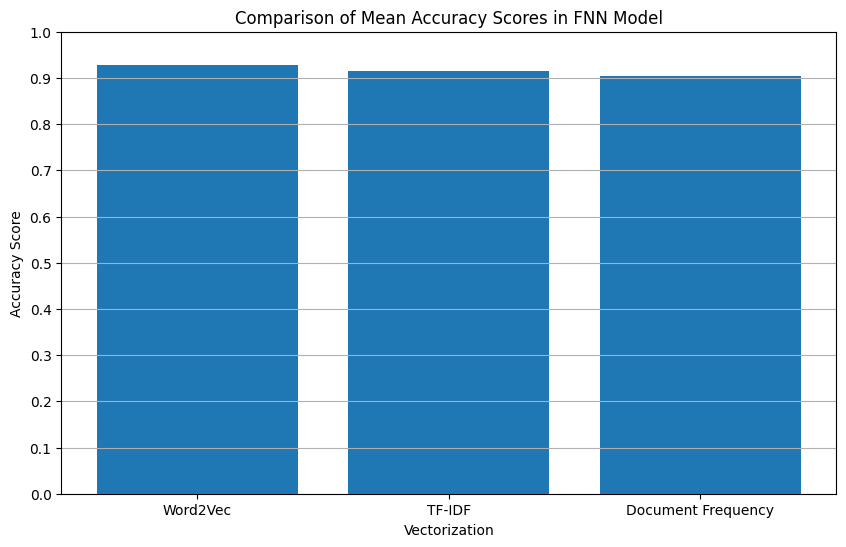

In [167]:
index = ['Word2Vec', 'TF-IDF', 'Document Frequency']  #  Categories on the x-axis
score = [fnn_accuracy1, fnn_accuracy2, fnn_accuracy3]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.ylim([0, 1])
plt.yticks([i * 0.1 for i in range(11)])
plt.grid(axis='y')  # adds grid lines to the y-axis
plt.bar(index, score)

# Add tags and titles
plt.xlabel('Vectorization')  
plt.ylabel('Accuracy Score')  
plt.title('Comparison of Mean Accuracy Scores in FNN Model') 

plt.show()

It can be seen from the above results that when the settings of the FNN model remain the same, the input features represented by the three vectorization methods, namely TF-IDF, document frequency and Word2Vec, all enable the model to achieve a relatively high accuracy. However, the combination of **Word2Vec and the FNN model** has a slight edge.

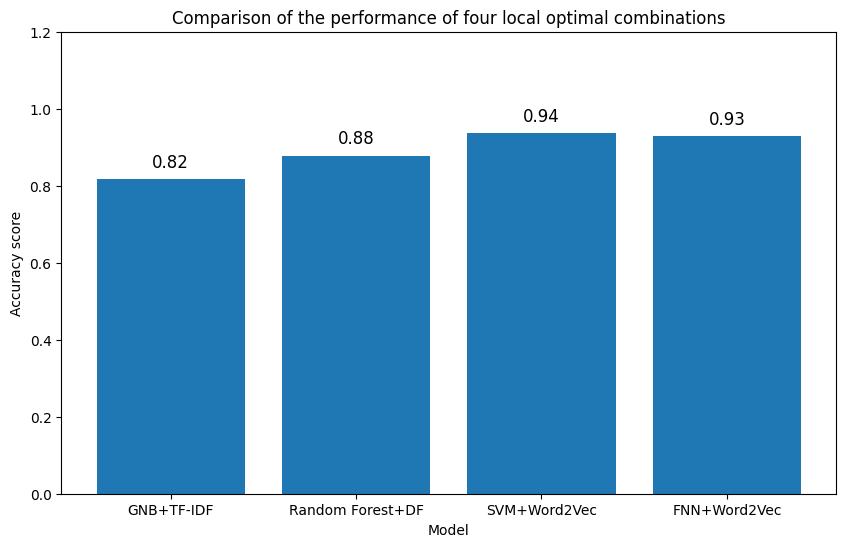

In [174]:
index = ['GNB+TF-IDF', 'Random Forest+DF', 'SVM+Word2Vec', 'FNN+Word2Vec']  #  Categories on the x-axis
score = [gnb_accuracy, rf_accuracy, svc_accuracy, fnn_accuracy1]  # The corresponding y-axis score

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.ylim([0, 1.2])

# Add text labels above each bar
bars = plt.bar(index, score)
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02,  # Adjust the position of the text
             f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

# Add tags and titles
plt.xlabel('Model')  
plt.ylabel('Accuracy score')  
plt.title('Comparison of the performance of four local optimal combinations') 

plt.show()

In [175]:
print('The best accuracy score is', svc_accuracy)

The best accuracy score is 0.9370192307692308


## 4 Conclusion
With the word embedding dimensions controlled, the optimal combination was the pairing of **Support Vector Machine with a nonlinear kernel and Word2Vec**, with accuracy rate approximately **93.7%** in the news classification task.
